In [2]:
!pip install seaborn

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix


# --- KONFIGURASI GPU ---
# Kode ini mencegah GPU langsung memakan 100% VRAM saat inisialisasi
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

# Konfigurasi Seed agar hasil bisa direproduksi
print("Versi TF:", tf.__version__) # Harus 2.10.x
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)
print("Nama Device:", tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.random.set_seed(42)
np.random.seed(42)

Versi TF: 2.20.0
GPU Available: False
Nama Device: []
Num GPUs Available:  0


In [4]:
# Path Dataset (Sesuaikan dengan folder lokal Anda)
DATA_DIR = "D:\\Kuliah\\Semester 5\\HUMIC\\dataset gabungan"

# Parameter Gambar
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3
BATCH_SIZE = 16  # Kurangi jika VRAM GPU < 4GB

# Hyperparameter Optimal (dari Paper)
LEARNING_RATE = 0.000506
NEURONS_FLN = 471
DROPOUT_RATE = 0.44
EPOCHS = 20      # Bisa ditambah, kita pakai EarlyStopping nanti
NUM_CLASSES = 3  # Benign, Malignant, Normal

In [5]:
def apply_clahe_preprocessing(img):
    """
    Menerapkan CLAHE pada citra input.
    Input: Citra (numpy array), format RGB atau BGR.
    Output: Citra setelah CLAHE dan preprocess DenseNet.
    """
    # Pastikan tipe data uint8 untuk OpenCV
    img = img.astype('uint8')
    
    # 1. Konversi RGB ke LAB
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    
    # 2. Terapkan CLAHE pada channel L (Lightness)
    # Paper menyarankan clipLimit 2.0-4.0 dan grid 8x8
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    # 3. Gabungkan kembali
    limg = cv2.merge((cl, a, b))
    
    # 4. Konversi kembali ke RGB
    final_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    
    # 5. Preprocessing spesifik DenseNet (Scaling & Normalization)
    # Ini penting agar sesuai dengan bobot pre-trained ImageNet
    final_img = tf.keras.applications.densenet.preprocess_input(final_img)
    
    return final_img

print("Fungsi CLAHE siap digunakan.")

Fungsi CLAHE siap digunakan.


In [6]:
# Augmentasi Data Training [cite: 105-114]
train_datagen = ImageDataGenerator(
    preprocessing_function=apply_clahe_preprocessing, # CLAHE diterapkan di sini
    rotation_range=20,         # Rotasi +/- 20 derajat
    width_shift_range=0.1,     # Geser horizontal
    height_shift_range=0.1,    # Geser vertikal
    horizontal_flip=True,      # Flip kiri-kanan (Valid medis)
    vertical_flip=False,       # JANGAN flip vertikal (Bayangan akustik harus di bawah)
    zoom_range=0.2,            # Simulasi variasi ukuran tumor
    validation_split=0.2       # 20% data untuk validasi/test
)

# Generator Data
print("Menyiapkan Data Training...")
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

print("\nMenyiapkan Data Validasi...")
validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False # Jangan di-shuffle agar urutan label benar saat evaluasi
)

class_names = list(train_generator.class_indices.keys())
print(f"\nKelas yang ditemukan: {class_names}")

Menyiapkan Data Training...
Found 826 images belonging to 3 classes.

Menyiapkan Data Validasi...
Found 204 images belonging to 3 classes.

Kelas yang ditemukan: ['test', 'train', 'validation']


In [7]:
def build_hybrid_model():
    # 1. Input Layer
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
    
    # 2. Backbone: DenseNet201 (Transfer Learning)
    # preprocessing_input sudah dilakukan di datagen, jadi kita langsung masuk model
    base_model = DenseNet201(
        include_top=False,      # Buang layer klasifikasi asli
        weights='imagenet',     # Pakai bobot yang sudah pintar
        input_tensor=inputs,
        pooling='avg'           # Global Average Pooling
    )
    
    # Bekukan backbone agar bobot ImageNet tidak rusak saat awal training
    base_model.trainable = False 
    
    # Output dari backbone (Fitur Vector 1920 dimensi)
    features = base_model.output
    
    # 3. Fast Learning Network (FLN) Head
    # Jalur A: Hidden Layer (Non-Linear)
    hidden_path = layers.Dense(NEURONS_FLN, activation='relu', name='fln_hidden')(features)
    hidden_path = layers.Dropout(DROPOUT_RATE, name='fln_dropout')(hidden_path)
    
    # Jalur B: Direct Path (Linear/Bypass)
    # Fitur asli langsung diteruskan tanpa diubah
    
    # Penggabungan (Concatenate) Jalur A dan Jalur B
    concatenated = layers.concatenate([hidden_path, features], name='fln_concat')
    
    # 4. Output Layer
    outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='prediction')(concatenated)
    
    # Build Model
    model = Model(inputs=inputs, outputs=outputs, name="DenseNet201_FLN_Hybrid")
    return model

model = build_hybrid_model()
model.summary()

Model: "DenseNet201_FLN_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 19,233,951 (73.37 MB)

 Trainable params: 911,967 (3.48 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [8]:


# 1. Definisi Scheduler: ReduceLROnPlateau
# Mekanisme: "Jika val_accuracy tidak naik selama 3 epoch, bagi Learning Rate dengan 2"
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',   # Metric yang dipantau
    factor=0.5,               # Faktor penurunan (LR baru = LR lama * 0.5)
    patience=3,               # Tunggu 3 epoch sebelum menurunkan LR
    min_lr=1e-6,              # Batas bawah LR (jangan lebih kecil dari ini)
    verbose=1                 # Tampilkan pesan di output saat LR berubah
)

# 2. Checkpoint & Early Stopping (Masih sama seperti sebelumnya)
checkpoint = ModelCheckpoint(
    'best_model_breast_cancer.keras', 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=8,               # Kita perpanjang dikit karena ada LR Scheduler
    restore_best_weights=True
)

# 3. Compile Model dengan Learning Rate Awal dari Paper
# [cite_start]Pastikan parameter learning_rate sesuai hasil optimasi paper [cite: 211]
initial_lr = 0.000506 
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Training
print(f"🚀 Mulai Training dengan Initial LR: {initial_lr}")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=25,  # Tambah epoch agar LR Scheduler punya waktu untuk bekerja
    callbacks=[checkpoint, early_stopping, lr_scheduler] # Masukkan lr_scheduler ke sini
)

🚀 Mulai Training dengan Initial LR: 0.000506
Epoch 1/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6850 - loss: 1.1210
Epoch 1: val_accuracy improved from None to 0.83854, saving model to best_model_breast_cancer.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.7691 - loss: 0.8409 - val_accuracy: 0.8385 - val_loss: 0.6324 - learning_rate: 5.0600e-04
Epoch 2/25
 1/51 ━━━━━━━━━━━━━━━━━━━━ 20s 413ms/step - accuracy: 0.8125 - loss: 0.6967

d:\Kuliah\Semester 5\HUMIC\DenseNet201-Breast-Cancer-Classification\humic1\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.83854 to 0.85417, saving model to best_model_breast_cancer.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.8125 - loss: 0.6967 - val_accuracy: 0.8542 - val_loss: 0.6455 - learning_rate: 5.0600e-04
Epoch 3/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.7719 - loss: 0.6794
Epoch 3: val_accuracy did not improve from 0.85417
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 576ms/step - accuracy: 0.7877 - loss: 0.6686 - val_accuracy: 0.8542 - val_loss: 0.4960 - learning_rate: 5.0600e-04
Epoch 4/25
 1/51 ━━━━━━━━━━━━━━━━━━━━ 28s 562ms/step - accuracy: 0.8125 - loss: 0.6543
Epoch 4: val_accuracy did not improve from 0.85417
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.8125 - loss: 0.6543 - val_accuracy: 0.8542 - val_loss: 0.5248 - learning_rate: 5.0600e-04
Epoch 5/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8052 - loss: 0.6614
Epoch 5: val_accuracy did not improve from 0.85417

Epoch 5: ReduceLROnPlateau reducing learning rate 

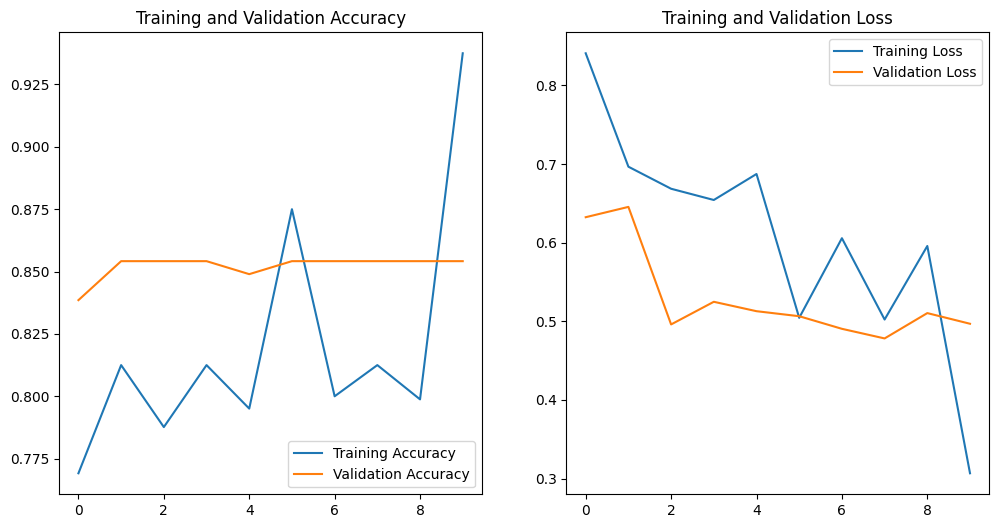

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [1]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block32_concat", pred_index=None):
    # 1. Buat model yang memetakan input ke aktivasi layer konvolusi terakhir dan output
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # 2. Rekam gradien
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # 3. Hitung gradien output terhadap feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # 4. Global Average Pooling pada gradien
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 5. Kalikan feature map dengan bobot gradien
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # 6. Normalisasi Heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, model):
    # Load Image manual
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    
    # Preprocess
    img_processed = apply_clahe_preprocessing(original_img)
    img_array = np.expand_dims(img_processed, axis=0)

    # Hapus softmax di layer terakhir agar gradien lebih tajam (opsional tapi disarankan)
    model.layers[-1].activation = None

    # Generate Heatmap
    # Layer 'conv5_block32_concat' adalah layer output terakhir DenseNet201
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block32_concat")

    # Tampilkan
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Citra Asli")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(original_img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5) # Overlay
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.show()

# --- CONTOH PENGGUNAAN ---
# Ganti dengan path file gambar USG asli yang ingin dites
# display_gradcam("dataset/malignant/malignant (10).png", best_model)